# Introduction
This notebook is used to validate the dataset. It is used to check if the dataset created in the fastf1_test.ipynb file is acceptable.

In [2]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
path = os.path.join('data', '2019', 'bahrain_grand_prix.csv')
df = pd.read_csv(
    path,
    dtype={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'Rainfall': np.bool8,
    'TrackTemp': np.float32,
    'WindDirection': np.int32,
    'WindSpeed': np.float32
    },
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   LapStartTime           1081 non-null   float32 
 1   LapNumber              1081 non-null   uint8   
 2   LapTime                1059 non-null   float32 
 3   DriverNumber           1081 non-null   category
 4   Compound               1081 non-null   category
 5   TyreLife               1081 non-null   uint8   
 6   TrackStatus            1081 non-null   category
 7   Stint                  1081 non-null   uint8   
 8   DistanceToDriverAhead  1005 non-null   float32 
 9   DriverAhead            1005 non-null   category
 10  PitStatus              1081 non-null   category
 11  IsAccurate             1081 non-null   bool    
 12  Track                  1081 non-null   category
 13  AirTemp                1081 non-null   float32 
 14  Humidity               1081 non-null   f

<AxesSubplot: xlabel='LapNumber', ylabel='LapTime'>

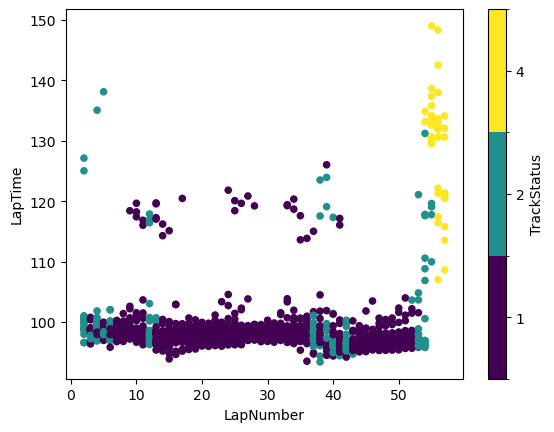

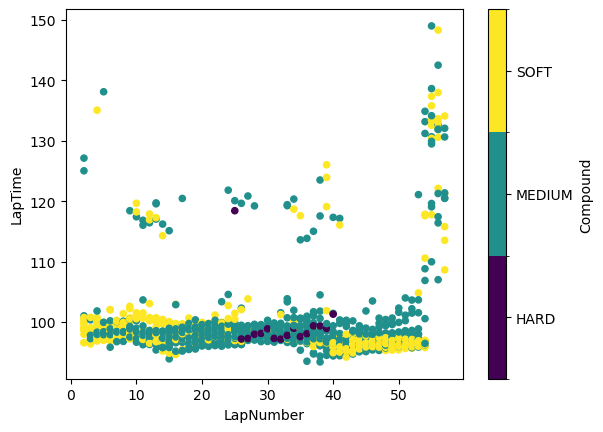

In [5]:
df.plot(
    x='LapNumber',
    y='LapTime', 
    colormap='viridis',
    c='TrackStatus',
    kind='scatter')

df.plot(
    x='LapNumber',
    y='LapTime',
    colormap='viridis',
    c='Compound',
    kind='scatter')
